# IMDB Sentiment Analysis With Transformer Encoder

用 Bert + Transformer 的编码器部分 + 全连接层 做 IMDB 电影评论文本情感分析。

In [1]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from swifter import swifter

import util
import sentiment_dataset as sed

In [2]:
EN_BERT_PATH = './data/bert-base-uncased'
IMDB_FILE = './data/IMDB Dataset.csv'

batch_size, num_epochs = 25, 15

## 1. 数据预处理

In [3]:
df = pd.read_csv(IMDB_FILE)
df = df.sample(n=50)
df

,review,sentiment
27206,Seemingly intended to be a thriller of a movie...,negative
48303,Well I gave this movie a 7. It was better than...,positive
2211,If any movie stands out extremely with the act...,positive
24028,<br /><br />***************************MILD SP...,positive
8177,Dan Katzir has produced a wonderful film that ...,positive
26523,"Okay, now what the hell is this supposed to be...",negative
4598,It's been a looooonnnggg time since I saw this...,negative
35589,"Set in Hungary in November 1956, this is the s...",positive
42051,My partner and I had never heard of this movie...,positive
20185,By today's standards The DI might seem a littl...,positive


In [4]:
df['sentiment'].value_counts()

positive    26
negative    24
Name: sentiment, dtype: int64

In [5]:
# 去除 html 标签
def remove_html_label(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

X = df['review'].swifter.apply(remove_html_label).tolist()
y = df['sentiment'].swifter.apply(lambda e: 1 if e == 'positive' else 0).tolist()

Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
# 看一下 corpus 的 平均长度 和 最大长度
l = [len(x) for x in X]
np.mean(l), np.max(l)

(1365.94, 3616)

## 2. 加载数据集

将数据集分割成训练集和测试集，然后用 Dataset 的子类 `SentimentDataset` 加载训练集和测试集。

为了程序能在多线程环境下正确运行，将以下代码写入 `sentiment_dataset.py` 文件并导入。

```python
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }
```

In [7]:
# 分割训练集和测试集（其实是验证集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=80)

tokenizer = BertTokenizer.from_pretrained(EN_BERT_PATH)

train_dataset = sed.SentimentDataset(X_train, y_train, tokenizer, max_len=512)
test_dataset = sed.SentimentDataset(X_test, y_test, tokenizer, max_len=512)

# train_dataset[13]

In [8]:
len(train_dataset)

40

In [9]:
# 用 DataLoader 加载数据
train_iter = DataLoader(train_dataset,
                        batch_size,
                        shuffle=True,
                        num_workers=4)
test_iter = DataLoader(test_dataset,
                       batch_size,
                       shuffle=True,
                       num_workers=4)

In [10]:
test_iter

## 3. 定义模型

我们的模型结构是 Bert + TransformerEncoder，注意这里 Bert 的参数是可更新的。

图省事直接用 `torch.nn` 写

- [nn.TransformerEncoderLayer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html)
- [nn.TransformerEncoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)

In [11]:
class BertTransformerEncoder(nn.Module):
    def __init__(self, n_classes, nhead=8, d_model=768, num_layers=6):
        super().__init__()
        self.bert = BertModel.from_pretrained(EN_BERT_PATH)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.drop = nn.Dropout(p=0.2)
        self.out = nn.Linear(d_model, n_classes)

    def forward(self, input_ids, attention_mask):
        # 用 bert 代替 nn.Embedding
        bert_outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        encoder_hidden_states = bert_outputs.last_hidden_state  # [batch_size, seq_len, hidden_dim]
        
        # transformer encoder -> pooling -> dropout -> fully_connected_layer
        encoded_output = self.transformer_encoder(encoder_hidden_states)
        # 通过池化获得句子级别的表征
        pooled_output = encoded_output.mean(dim=1)
        # 通过 dropout 防止过拟合
        x = self.drop(pooled_output)
        # 最后接一个全连接层
        return self.out(x)

In [12]:
model = BertTransformerEncoder(n_classes=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

Some weights of the model checkpoint at ./data/bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/Users/changluo/anaconda3/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_

In [13]:
# 损失函数
loss = nn.CrossEntropyLoss(reduction='none')

# 优化器
optimizer = torch.optim.Adam(model.parameters())

## 4. 训练模型

In [14]:
def evaluate_accuracy(net, data_iter, device):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = util.Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for data in data_iter:
            y_hat = net(input_ids=data['input_ids'].to(device),
                        attention_mask=data['attention_mask'].to(device))
            y = data['label'].to(device)
            metric.add(util.accuracy(y_hat, y), y.numel())
    return metric[0] / metric[1]

In [15]:
def train_epoch(net, train_iter, loss, updater, device):
    """训练模型一个迭代周期"""

    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()

    # 训练损失总和、训练准确度总和、样本数
    metric = util.Accumulator(3)
    for data in train_iter:
        # 计算梯度并更新参数
        y_hat = model(input_ids=data['input_ids'].to(device),
                      attention_mask=data['attention_mask'].to(device))

        y = data['label'].to(device)
        l = loss(y_hat, y)

        # 使用PyTorch内置的优化器和损失函数
        updater.zero_grad()
        l.mean().backward()
        updater.step()

        metric.add(float(l.sum()), util.accuracy(y_hat, y), y.numel())

    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [16]:
def train(net, train_iter, test_iter, loss, num_epochs, updater, device):
    """训练模型"""
    animator = util.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.0],
                        legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater, device)
        test_acc = evaluate_accuracy(net, test_iter, device)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics

    print(f'train_loss: {train_loss:.3f}')
    print(f'train_acc: {train_acc:.3f}')
    print(f'test_acc: {test_acc:.3f}')

train_loss: 0.702
train_acc: 0.575
test_acc: 0.300


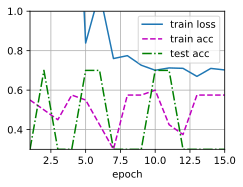

In [17]:
train(net=model,
      train_iter=train_iter,
      test_iter=test_iter,
      loss=loss,
      num_epochs=num_epochs,
      updater=optimizer,
      device=device)

因为我电脑性能的原因，只用了 50 个句子 + 15 个 epochs 进行训练。

看起来随着训练轮次的增加，loss 还有继续下降的潜力。